# Introduction to 🤗 Diffusers

In [ ]:
pip install diffusers["torch"] transformers

In [ ]:
import torch
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.auto import tqdm

## Diffuser?

- 허깅페이스에서 만든 이미지, 오디오, 심지어 분자의 3D 구조까지 생성하기 위해 사전 훈련된 최첨단 diffusion 모델을 위한 라이브러리

- 크게 모델과 스케쥴러로 구성되며 세부적으로 오톤인코더 토크나이저, 텍스트 인코더 등이 있음

## 이 파일에서 학습할 내용

- 파이프라인을 사용하여 간편하게 이미지를 생성하는 방법

- 파이프라인을 해체하여 라이브러리를 모듈식 도구 상자로 사용하여 커스텀 diffusion 모델을 구축하는 방법




## DDPM

- 조건없이 이미지를 생성하는 노이제 제거 모델의 가장 기본적인 형태

### 파이프라인

- 모델과 스케쥴러가 함께 있는 클래스

- 클래스를 변수화하여 바로 이미지 생성 가능

In [ ]:
# 파이프 라인 임포트
from diffusers import DDPMPipeline

- DDPM 모델을 고양이 이미지에 학습한 모델을 파이프라인으로 로딩
    - model: `UNet2DModel`
    - scheduler: `DDPMScheduler`

- https://huggingface.co/google/ddpm-cat-256

In [ ]:
# 모델 + 스케쥴러가 함께 있는 파이프라인 생성
ddpm = DDPMPipeline.from_pretrained(
    "google/ddpm-cat-256",  # model
    # use_safetensors=True # 가중치를 세이프텐서형태로 로딩(필수 아님)
    # If set to None, the safetensors weights are downloaded if they're available **and** if the
    # safetensors library is installed. If set to True, the model is forcibly loaded from safetensors
    # weights. If set to False, safetensors weights are not loaded
).to("cuda")

Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

- 이미지 생성과 확인

In [ ]:
torch.manual_seed(0)

# 이미지 생성
images = ddpm(
    batch_size=3, # 생성 이미지 개수
    num_inference_steps=50 # 노이즈 제거 스탭
).images

  0%|          | 0/50 [00:00<?, ?it/s]

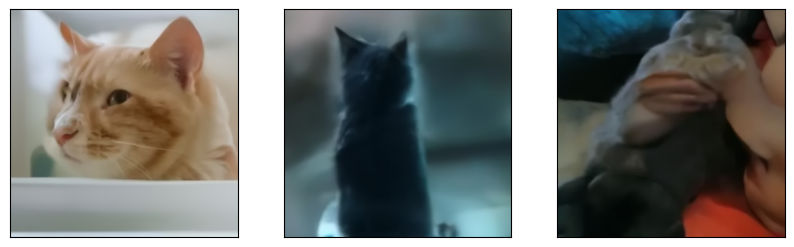

In [ ]:
fig, ax = plt.subplots(figsize=(10,3), nrows=1, ncols=3)

for i in range(3):
    ax[i].imshow(images[i])
    ax[i].xaxis.set_major_locator(plt.NullLocator())
    ax[i].yaxis.set_major_locator(plt.NullLocator())

plt.show()

### 모델 & 스케쥴러

- 모델과 스케쥴러를 별도로 임포트하여 노이즈 제거 단계를 직접 수행

In [ ]:
# 모델과 스케쥴러 임포트
from diffusers import DDPMScheduler, UNet2DModel

model = UNet2DModel.from_pretrained("google/ddpm-cat-256", use_safetensors=True).to("cuda")
scheduler = DDPMScheduler.from_pretrained("google/ddpm-cat-256")

- 노이즈 제거 프로세스를 실행할 타임스텝 수를 설정

In [ ]:
scheduler.set_timesteps(50)

In [ ]:
# 1000스탭에서 20씩 건너뛰면서 타입 스탭이 생성
scheduler.timesteps

tensor([980, 960, 940, 920, 900, 880, 860, 840, 820, 800, 780, 760, 740, 720,
        700, 680, 660, 640, 620, 600, 580, 560, 540, 520, 500, 480, 460, 440,
        420, 400, 380, 360, 340, 320, 300, 280, 260, 240, 220, 200, 180, 160,
        140, 120, 100,  80,  60,  40,  20,   0])

- 모델과 스케쥴러를 직접 사용하여 노이즈 제거 루프를 구성

In [ ]:
# 모델이 생성하는 이미지 사이즈
sample_size = model.config.sample_size
sample_size

256

In [ ]:
# 랜덤 노이즈
generator = torch.manual_seed(10)
noise = torch.randn((1, 3, sample_size, sample_size),
                    generator=generator).to('cuda')

#### 단계별 노이즈 제거

In [ ]:
input = noise

for t in scheduler.timesteps:
    # 모델이 노이즈를 예측
    with torch.no_grad():
        noisy_residual = model(input, t).sample
    # 모델의 예측으로 부터 이전 단계(노이즈가 줄어든) 이미지 샘플링
    previous_noisy_sample = scheduler.step(noisy_residual, t, input).prev_sample

    # input 업데이트
    input = previous_noisy_sample

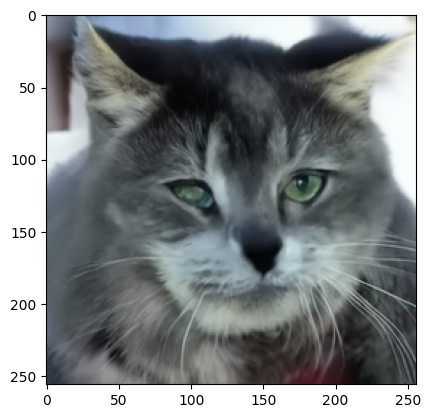

In [ ]:
image = (input / 2 + 0.5).clamp(0, 1).squeeze()
image = (image.permute(1, 2, 0) * 255).round().to(torch.uint8).cpu().numpy()

plt.imshow(image)
plt.show()

## Stable Diffusion(SD)

- [High-Resolution Image Synthesis with Latent Diffusion Models](https://arxiv.org/abs/2112.10752)에서 제안한 모델을 Stability AI의 투자로 CompVis 그룹과  런웨이(Runway)에서 개발한 구현체

- LDM: https://github.com/CompVis/latent-diffusion

- Stable Diffusion: https://github.com/CompVis/stable-diffusion

- 🤗 Diffusers에서 SD 구성 요소인 이미지 오토인코더, 토크나이저, 텍스트 인코더, 노이즈 제거 모델을 모두 제공

#### 구성요소 준비

In [ ]:
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, PNDMScheduler

In [ ]:
# 구성 요소 4개를 생성

# 이미지 <---> 잠재 공간을 담당하는 모델
vae = AutoencoderKL.from_pretrained(
    "CompVis/stable-diffusion-v1-4",
    subfolder="vae", use_safetensors=True)

# 텍스트 컨디션을 토크나이징하는 토크나이저
tokenizer = CLIPTokenizer.from_pretrained(
    "CompVis/stable-diffusion-v1-4",
    subfolder="tokenizer")

# 텍스트 컨디션 인코더
text_encoder = CLIPTextModel.from_pretrained(
    "CompVis/stable-diffusion-v1-4",
    subfolder="text_encoder", use_safetensors=True)

# 노이즈 제거 모델
unet = UNet2DConditionModel.from_pretrained(
    "CompVis/stable-diffusion-v1-4",
    subfolder="unet", use_safetensors=True
)

In [ ]:
from diffusers import UniPCMultistepScheduler

# 우선은 기본 스케쥴러로 실험
# 스케쥴러 바꾸면 우주인 다리 부분이 좀 깔끔해짐
scheduler = PNDMScheduler.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="scheduler")
# scheduler = UniPCMultistepScheduler.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="scheduler")

In [ ]:
torch_device = "cuda"

vae.to(torch_device)
text_encoder.to(torch_device)
unet.to(torch_device)

UNet2DConditionModel(
  (conv_in): Conv2d(4, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): LoRACompatibleLinear(in_features=320, out_features=1280, bias=True)
    (act): SiLU()
    (linear_2): LoRACompatibleLinear(in_features=1280, out_features=1280, bias=True)
  )
  (down_blocks): ModuleList(
    (0): CrossAttnDownBlock2D(
      (attentions): ModuleList(
        (0-1): 2 x Transformer2DModel(
          (norm): GroupNorm(32, 320, eps=1e-06, affine=True)
          (proj_in): LoRACompatibleConv(320, 320, kernel_size=(1, 1), stride=(1, 1))
          (transformer_blocks): ModuleList(
            (0): BasicTransformerBlock(
              (norm1): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
              (attn1): Attention(
                (to_q): LoRACompatibleLinear(in_features=320, out_features=320, bias=False)
                (to_k): LoRACompatibleLinear(in_features=320, out_features=320

#### 프롬프트 준비

In [ ]:
prompt = ["a photograph of an astronaut riding a horse"]
height = 512  # default height of Stable Diffusion
width = 512  # default width of Stable Diffusion
num_inference_steps = 25  # Number of denoising steps
guidance_scale = 7.5  # Scale for classifier-free guidance
generator = torch.manual_seed(2)  # Seed generator to create the initial latent noise
batch_size = len(prompt)

In [ ]:
text_input = tokenizer(
    prompt, max_length=tokenizer.model_max_length,
    padding="max_length", truncation=True, return_tensors="pt"
)

# 시퀀스 길이 77
print(len(text_input['input_ids'][0]))

# 토큰화 결과
text_input

77


{'input_ids': tensor([[49406,   320,  8853,   539,   550, 18376,  6765,   320,  4558, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0]])}

In [ ]:
with torch.no_grad():
    text_embeddings = text_encoder(text_input['input_ids'].to(torch_device))[0]

# 각 토큰은 768차원 벡터로 임베딩
text_embeddings.shape

torch.Size([1, 77, 768])

- You’ll also need to generate the unconditional text embeddings which are the embeddings for the padding token. These need to have the same shape (batch_size and seq_length) as the conditional text_embeddings:

- 이 부분 모르겠다고 메모되어있는데 메모에 CFG관련 내용이라 하고 알아냈다고 만 되어있음(다시 알아내야 함)

- 일단 CFG를 쓰는 모델은 컨디션이 있는 상태와 컨디션이 없는 상태에 무작위로 학습되어서 컨디션 있는 이미지도 생성하고 무컨디션 이미지도 생성하게 됨

- 그 다음 classifier가 있는 경우 이 clf를 노이즈로 미분한 그래디언트를 네트워크의 출력에 빼서 마치 경사 하강하듯이 네트워크의 출력을 해당 클래스에 가깝게 변경하게되는데 이때 그래디언트 역학을 하는 것이 무조건으로 생성된 출력물이 되는것 같음

- 그래서 CFG를 하려면 무조건 상태에서 생성된 이미지도 필요해지게 됨

- 일단 첫날 이정도 복구 했고 CG논문을 다시 읽어봐야 함(이번 주말)

In [ ]:
max_length = text_input['input_ids'].shape[-1]

# 모두 공백인 ""으로 채워서 텍스트 컨디션을 없는 것으로 만듬
uncond_input = tokenizer([""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt")

uncond_embeddings = text_encoder(uncond_input['input_ids'].to(torch_device))[0]

- 조건부 임베딩과 무조건 임베딩을 일괄 처리로 연결하여 두 번의 포워드 패스를 방지

In [ ]:
# (1, 77, 768), (1, 77, 768) => (2, 77, 768)
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

# 구체적인 조건이 있는것과 그냥 깡통 조건(모두 공백인)이 같이 묶임
text_embeddings.shape

torch.Size([2, 77, 768])

#### 랜덤 노이즈 생성

In [ ]:
latents = torch.randn(
    (batch_size, unet.config.in_channels, height // 8, width // 8),
    generator=generator,
).to(torch_device)

In [ ]:
# 이미지 512 가 VAE에서 3번 다운 샘플되서 64사이즈로 줄어든 잠재 변수
latents.shape

torch.Size([1, 4, 64, 64])

In [ ]:
# 3번 업샘플하면 512가 됨
64*2*2*2

512

In [ ]:
# 노이즈의 표준편차를 스케쥴레어 세팅된 표준편차로 맞춤
# 이걸 필요로 하는 스케쥴러가 있음
# PNDMScheduler, UniPCMultistepScheduler에 대해서 필요없음, 둘다 init_noise_sigma가 1.0
# latents = latents * scheduler.init_noise_sigma

In [ ]:
# 타임스탭 세팅
scheduler.set_timesteps(num_inference_steps)
scheduler.timesteps

tensor([999, 959, 919, 879, 839, 799, 759, 719, 679, 639, 599, 559, 519, 480,
        440, 400, 360, 320, 280, 240, 200, 160, 120,  80,  40])

#### 단계별 노이즈 제거

In [ ]:
for t in tqdm(scheduler.timesteps):
    # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
    latent_model_input = torch.cat([latents] * 2)

    # PNDMScheduler, UniPCMultistepScheduler에서 딱히 필요없는 것 같음
    # 입력을 타입스탭에 따라 스케쥴링하는 스케쥴러가 있은 듯 함
    # latent_model_input = scheduler.scale_model_input(latent_model_input, timestep=t)

    # predict the noise residual
    with torch.no_grad():
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

    # perform guidance
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    # CFG eq(6)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    # compute the previous noisy sample x_t -> x_t-1
    latents = scheduler.step(noise_pred, t, latents).prev_sample

  0%|          | 0/25 [00:00<?, ?it/s]

In [ ]:
# scale and decode the image latents with vae
#  0.18215는 SD개발자들이 찾아낸 디코딩이 잘되기 위한 상수
latents = 1 / 0.18215 * latents
with torch.no_grad():
    image = vae.decode(latents).sample

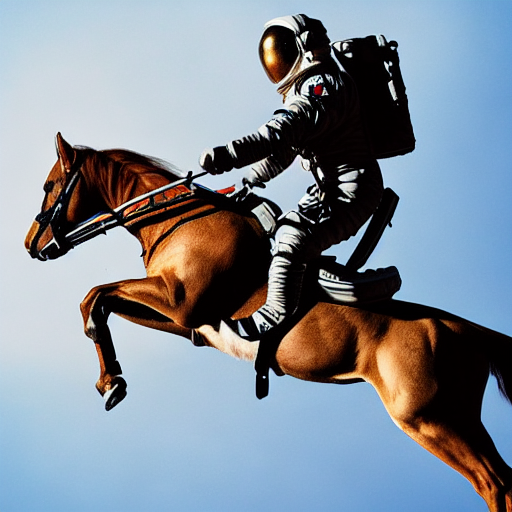

In [ ]:
image = (image / 2 + 0.5).clamp(0, 1).squeeze()
image = (image.permute(1, 2, 0) * 255).to(torch.uint8).cpu().numpy()
# images = (image * 255).round().astype("uint8")
image = Image.fromarray(image)
image

In [ ]:
# 여기 openai api 따위로 번역기 붙여서 파이프라인을 다시 구성하는 함수 만들기 실습
